In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv')  # replace with your file path
df.set_index("Year", inplace=True)
df = df.dropna()

In [3]:
df.columns

Index(['Unnamed: 0', 'Hurs', 'pr', 'tas', 'exchange_rate',
       'Trade_value_brazil_china', 'soy_production(ton)',
       'Soybean_production(h)', 'Export_Usa_china_MT', 'forest_loss_PA (h)',
       'forest_loss_SC (h)', 'natural_forest_loss (h)',
       'non_natural_forest_loss (h)'],
      dtype='object')

In [4]:
# time series
y = df['natural_forest_loss (h)']

# exogenous variables
X = df[['Hurs', 'pr', 'tas', 'soy_production(ton)',
       'Soybean_production(h)']]  # can include more variables if you have them

In [5]:
result = adfuller(y)
print(f"ADF statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

# if p > 0.05 → non-stationary, you may consider differencing:
if result[1] > 0.05:
    y_diff = y.diff().dropna()
    adf2 = adfuller(y_diff)
    print(f"Differenced ADF statistic: {adf2[0]:.3f}, p-value: {adf2[1]:.3f}")
else:
    y_diff = y  # already stationary

ADF statistic: -2.691
p-value: 0.076
Differenced ADF statistic: -1.775, p-value: 0.393


In [6]:
y_diff2 = y.diff().diff().dropna()
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(y_diff2)
print(f"2nd diff ADF statistic: {adf_result[0]}, p-value: {adf_result[1]}")

2nd diff ADF statistic: -2.908488598315743, p-value: 0.044369756169067964


X_test shape: (5, 5)
                                  SARIMAX Results                                  
Dep. Variable:     natural_forest_loss (h)   No. Observations:                   18
Model:                    SARIMAX(1, 1, 1)   Log Likelihood                -221.070
Date:                     Mon, 30 Jun 2025   AIC                            458.139
Time:                             13:47:03   BIC                            463.804
Sample:                                  0   HQIC                           458.079
                                      - 18                                         
Covariance Type:                       opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Hurs                   5.619e+05     50.345   1.12e+04      0.000    5.62e+05    5.62e+05
pr                     2656.2896   87

/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/proj3env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/proj3env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/proj3env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

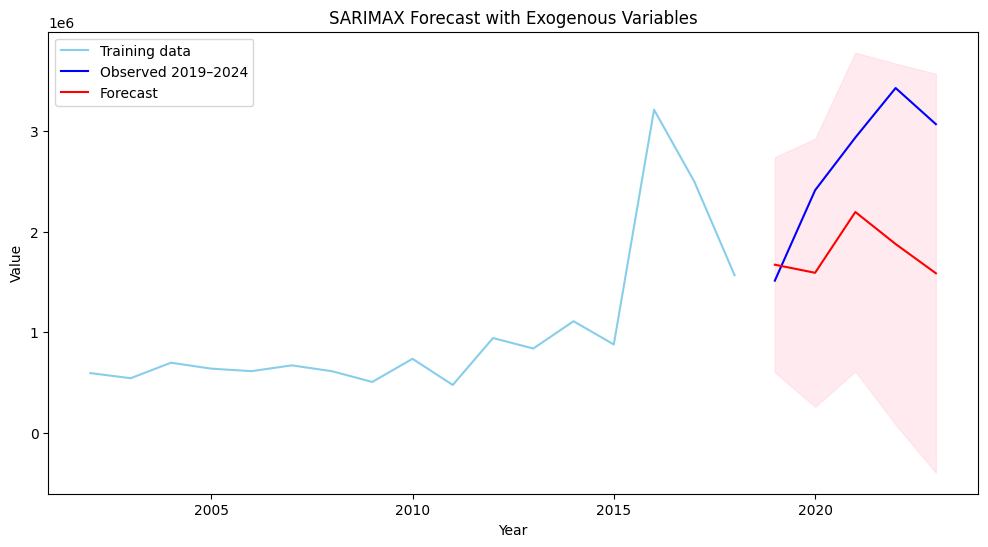

In [7]:
# -------------------------------
# 2. Train/test split
# -------------------------------

# train: 2002–2018
y_train = y.loc[2002:2018]
X_train = X.loc[2002:2018]

# test/forecast period: 2019–2024
y_test = y.loc[2019:2023]
X_test = X.loc[2019:2023]

# check shapes
print("X_test shape:", X_test.shape)

# if missing any years in X_test, you MUST fill them in:
expected_years = range(2019,2023)
missing_years = set(expected_years) - set(X_test.index)
if missing_years:
    print(f"Warning: missing exogenous data for years {missing_years}")
    # you can optionally fill them:
    for year in missing_years:
        # fill with last known values
        last_row = X_train.iloc[-1]
        X_test.loc[year] = last_row
    X_test = X_test.sort_index()

# -------------------------------
# 3. Fit SARIMAX model
# -------------------------------

# you found d=2 from ADF tests
model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

# -------------------------------
# 4. Forecast
# -------------------------------

forecast_steps = len(X_test)  # should be 6
forecast = results.get_forecast(steps=forecast_steps, exog=X_test)

predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# fix index to years
forecast_years = range(2019, 2024)
predicted_mean.index = forecast_years
conf_int.index = forecast_years

# -------------------------------
# 5. Plot results
# -------------------------------

plt.figure(figsize=(12,6))

# training data
plt.plot(y_train, label="Training data", color="skyblue")

# observed test data
plt.plot(y_test, label="Observed 2019–2024", color="blue")

# forecast
plt.plot(predicted_mean.index, predicted_mean, label="Forecast", color="red")

# confidence intervals
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='pink', alpha=0.3)

plt.legend()
plt.title("SARIMAX Forecast with Exogenous Variables")
plt.xlabel("Year")
plt.ylabel("Value")
plt.show()